# **Question 1**
We were required to use a pretrained diffusion model for generating specific images of hands. The choice of model was Playground which is base on Stable Diffusion XL

# Import statements

In [ ]:
from diffusers import DiffusionPipeline
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Loading the model

In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "playgroundai/playground-v2.5-1024px-aesthetic",
    torch_dtype=torch.float16,
    variant="fp16",
).to("cuda")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/497 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### Generate an image that contains 10 hands. Yes, in a single image.


  0%|          | 0/50 [00:00<?, ?it/s]

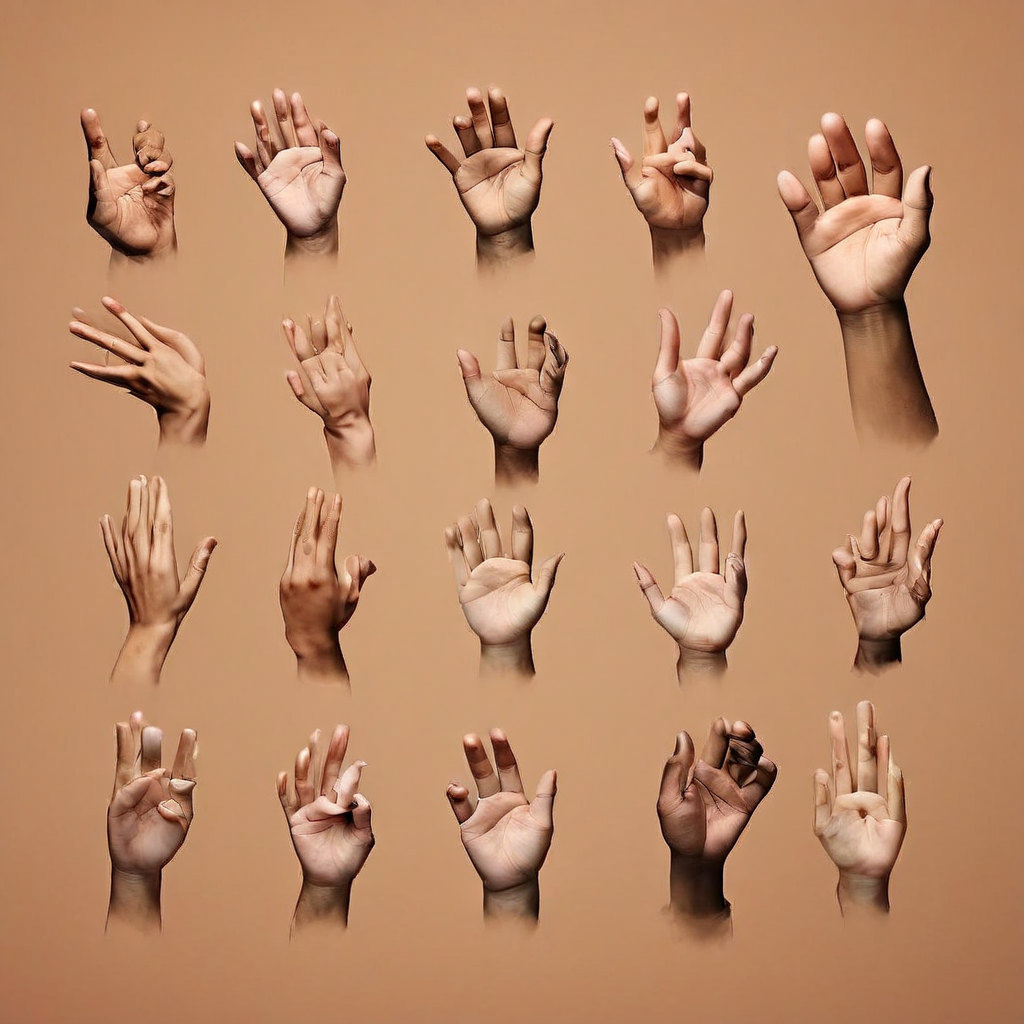

In [ ]:
prompt = "An artistic composition featuring 10 distinct hands, each in a unique animated pose. Each hand is detailed with accurately rendered fingers and realistic proportions. The hands are evenly spaced against a plain, neutral background, with no additional objects or distractions. Focus exclusively on the hands, ensuring variety in their gestures."
image = pipe(prompt=prompt, num_inference_steps=50, guidance_scale=3).images[0]

image

### Generate an image where two people are shaking hands.


  0%|          | 0/50 [00:00<?, ?it/s]

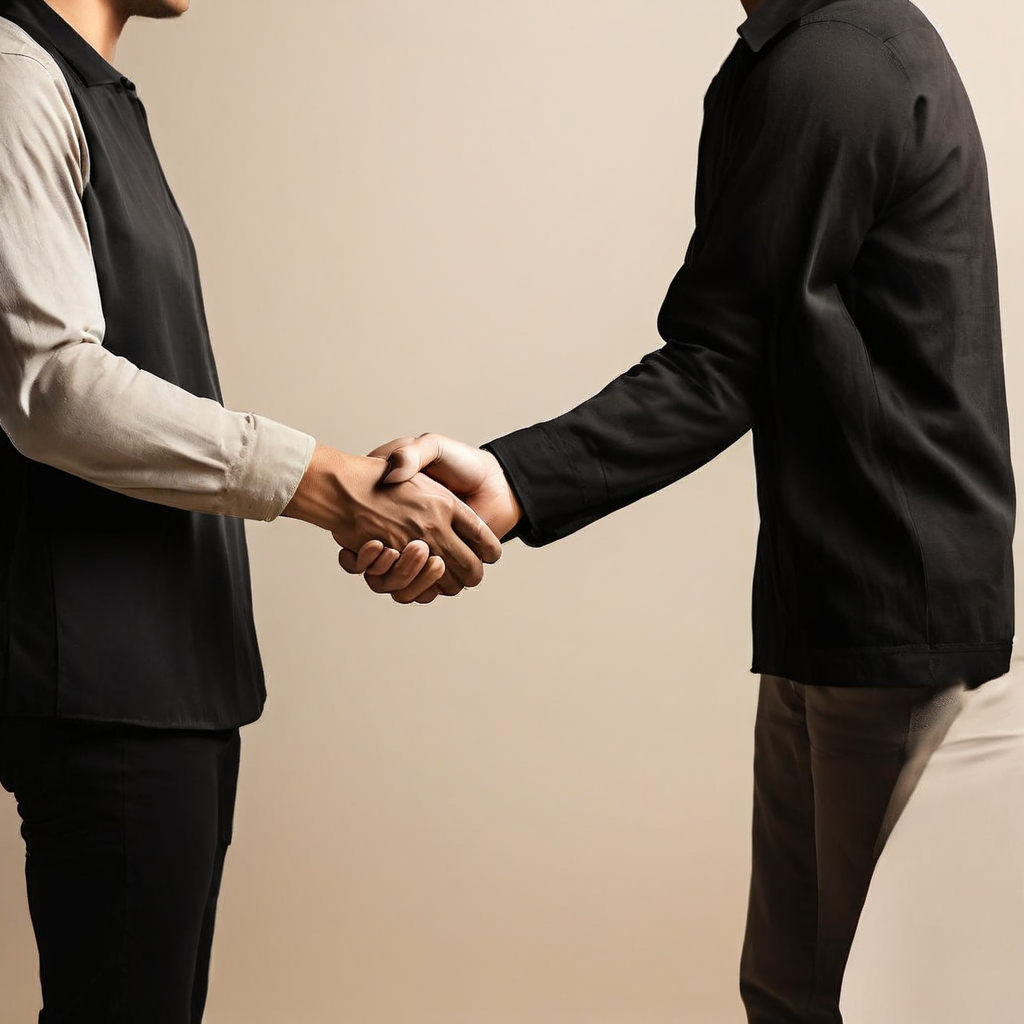

In [ ]:
prompt = "Two people shaking hands, focused on their clasped hands with clear detail. The background is neutral and minimalistic, highlighting the professional handshake."
image = pipe(prompt=prompt, num_inference_steps=50, guidance_scale=3).images[0]

image

### Generate an image where 5 people are performing a handshake simultaneously

  0%|          | 0/80 [00:00<?, ?it/s]

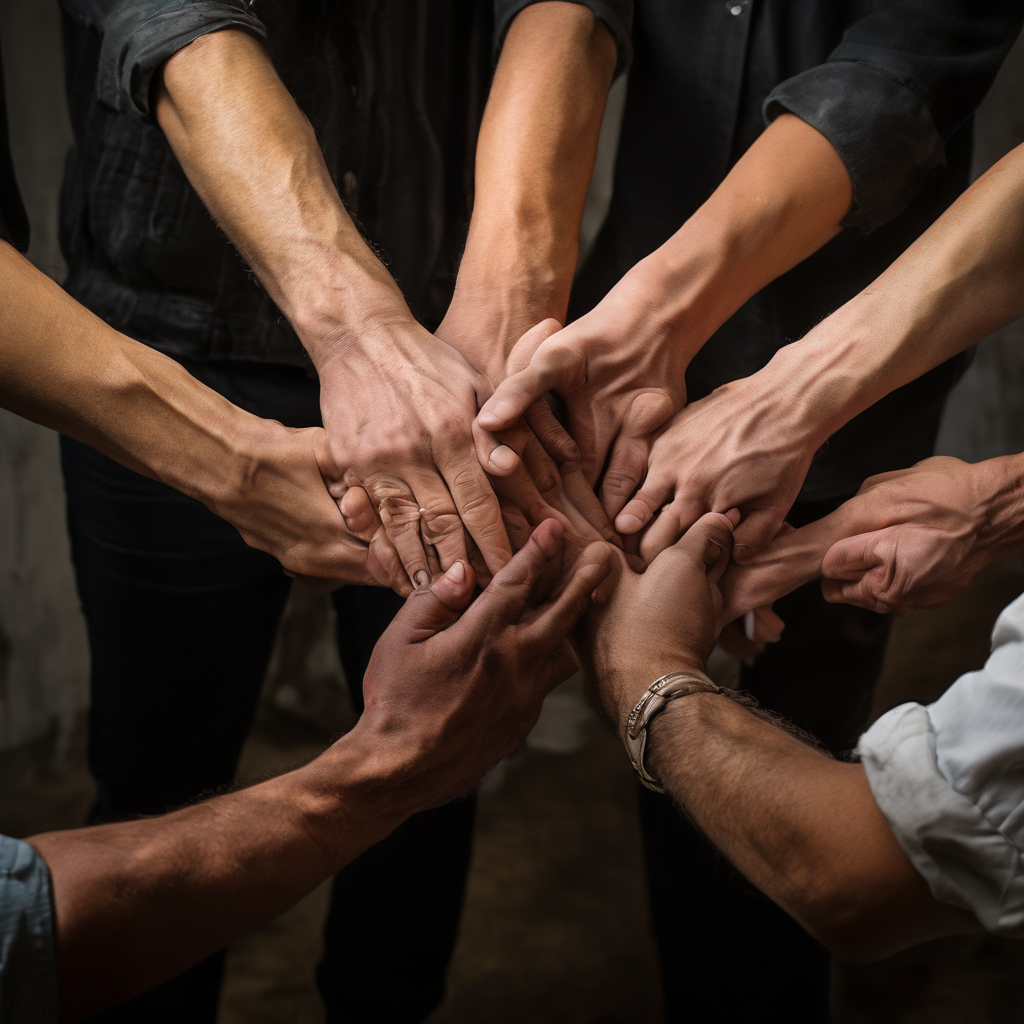

In [ ]:
prompt = "Five pairs of hands performing handshakes, clearly showing all ten hands in the frame."
image = pipe(prompt=prompt, num_inference_steps=80, guidance_scale=1).images[0]

image


# **Question 2**
Finetuning using hands dataset

# Issues Faced
1. No finetunning guide for our specific model i.e Playgorund. Had to use the guide for Stable diffusiion XL instead.
2. Model parameters were too big for loading on the available resources on Colab/ Kaggle. Had to use LoRa with several different permutations of hyperparameters. i.e. resolution, batch_input, mixed_fp_precision ect.
3. the provided dataset had 11000 images. If we trained on the entire dataset, the training was taking 23 hours. The online notebooks environments only allowed connection for 12 hours. This is why we ended up using 1000 images.
4. After finetuning on 50000 steps, the model outputted pure noise. Then after much testing, we realised that our learning rate was too big. Had to tweek it down to get any sensible resuslts.

In [ ]:
!pip install datasets transformers peft
!pip install --upgrade git+https://github.com/huggingface/diffusers.git


## Fine-tuning script for Stable Diffusion XL LoRA. This script was used as it is from the shared resources.

In [ ]:
import argparse
import logging
import math
import os
import random
import shutil
from contextlib import nullcontext
from pathlib import Path

import datasets
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import DistributedDataParallelKwargs, DistributedType, ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from peft import LoraConfig, set_peft_model_state_dict
from peft.utils import get_peft_model_state_dict
from torchvision import transforms
from torchvision.transforms.functional import crop
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig

import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    StableDiffusionXLPipeline,
    UNet2DConditionModel,
)
from diffusers.loaders import StableDiffusionLoraLoaderMixin
from diffusers.optimization import get_scheduler
from diffusers.training_utils import _set_state_dict_into_text_encoder, cast_training_params, compute_snr
from diffusers.utils import (
    check_min_version,
    convert_state_dict_to_diffusers,
    convert_unet_state_dict_to_peft,
    is_wandb_available,
)
from diffusers.utils.hub_utils import load_or_create_model_card, populate_model_card
from diffusers.utils.import_utils import is_torch_npu_available, is_xformers_available
from diffusers.utils.torch_utils import is_compiled_module


if is_wandb_available():
    import wandb

check_min_version("0.32.0.dev0")

logger = get_logger(__name__)
if is_torch_npu_available():
    torch.npu.config.allow_internal_format = False


def save_model_card(
    repo_id: str,
    images: list = None,
    base_model: str = None,
    dataset_name: str = None,
    train_text_encoder: bool = False,
    repo_folder: str = None,
    vae_path: str = None,
):
    img_str = ""
    if images is not None:
        for i, image in enumerate(images):
            image.save(os.path.join(repo_folder, f"image_{i}.png"))
            img_str += f"![img_{i}](./image_{i}.png)\n"

    model_description = f"""
# LoRA text2image fine-tuning - {repo_id}

These are LoRA adaption weights for {base_model}. The weights were fine-tuned on the {dataset_name} dataset. You can find some example images below. \n
{img_str}

LoRA for the text encoder was enabled: {train_text_encoder}.

Special VAE used for training: {vae_path}.
"""
    model_card = load_or_create_model_card(
        repo_id_or_path=repo_id,
        from_training=True,
        license="creativeml-openrail-m",
        base_model=base_model,
        model_description=model_description,
        inference=True,
    )

    tags = [
        "stable-diffusion-xl",
        "stable-diffusion-xl-diffusers",
        "text-to-image",
        "diffusers",
        "diffusers-training",
        "lora",
    ]
    model_card = populate_model_card(model_card, tags=tags)

    model_card.save(os.path.join(repo_folder, "README.md"))


def log_validation(
    pipeline,
    args,
    accelerator,
    epoch,
    is_final_validation=False,
):
    logger.info(
        f"Running validation... \n Generating {args.num_validation_images} images with prompt:"
        f" {args.validation_prompt}."
    )
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    # run inference
    generator = torch.Generator(device=accelerator.device).manual_seed(args.seed) if args.seed else None
    pipeline_args = {"prompt": args.validation_prompt}
    if torch.backends.mps.is_available():
        autocast_ctx = nullcontext()
    else:
        autocast_ctx = torch.autocast(accelerator.device.type)

    with autocast_ctx:
        images = [pipeline(**pipeline_args, generator=generator).images[0] for _ in range(args.num_validation_images)]

    for tracker in accelerator.trackers:
        phase_name = "test" if is_final_validation else "validation"
        if tracker.name == "tensorboard":
            np_images = np.stack([np.asarray(img) for img in images])
            tracker.writer.add_images(phase_name, np_images, epoch, dataformats="NHWC")
        if tracker.name == "wandb":
            tracker.log(
                {
                    phase_name: [
                        wandb.Image(image, caption=f"{i}: {args.validation_prompt}") for i, image in enumerate(images)
                    ]
                }
            )
    return images


def import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path: str, revision: str, subfolder: str = "text_encoder"
):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path, subfolder=subfolder, revision=revision
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel
        return CLIPTextModel
    elif model_class == "CLIPTextModelWithProjection":
        from transformers import CLIPTextModelWithProjection
        return CLIPTextModelWithProjection
    else:
        raise ValueError(f"{model_class} is not supported.")


def parse_args(input_args=None):
    parser = argparse.ArgumentParser(description="Simple example of a training script for SDXL LoRA fine-tuning.")

    # *** Updated defaults for model and dataset loading ***
    parser.add_argument(
        "--pretrained_model_name_or_path",
        type=str,
        default="playgroundai/playground-v2.5-1024px-aesthetic",  # Updated default
        required=False,
        help="Path to pretrained model or model identifier from huggingface.co/models.",
    )
    parser.add_argument(
        "--pretrained_vae_model_name_or_path",
        type=str,
        default=None,
        help="Path to pretrained VAE model with better numerical stability.",
    )
    parser.add_argument(
        "--revision",
        type=str,
        default=None,
        required=False,
        help="Revision of pretrained model identifier.",
    )
    parser.add_argument(
        "--variant",
        type=str,
        default=None,
        help="Variant of the model files (e.g. fp16)",
    )
    parser.add_argument(
        "--dataset_name",
        type=str,
        default=None,
        help="The name of a Dataset on the HuggingFace hub or path to local dataset.",
    )
    parser.add_argument(
        "--dataset_config_name",
        type=str,
        default=None,
        help="Config of the Dataset.",
    )
    parser.add_argument(
        "--train_data_dir",
        type=str,
        default="./new",  # Updated default
        help="A folder containing the training data.",
    )
    parser.add_argument(
        "--image_column", type=str, default="image", help="Column of the dataset containing an image."
    )
    parser.add_argument(
        "--caption_column",
        type=str,
        default="text",  # Updated default to text
        help="Column of the dataset containing a caption or a list of captions.",
    )
    parser.add_argument(
        "--validation_prompt",
        type=str,
        default=None,
        help="A prompt for validation.",
    )
    parser.add_argument(
        "--num_validation_images",
        type=int,
        default=4,
        help="Number of images generated during validation.",
    )
    parser.add_argument(
        "--validation_epochs",
        type=int,
        default=1,
        help="Run validation every X epochs.",
    )
    parser.add_argument(
        "--max_train_samples",
        type=int,
        default=None,
        help="For debugging or smaller training, limit the number of training examples.",
    )
    parser.add_argument(
        "--output_dir",
        type=str,
        default="sd-model-finetuned-lora",
        help="Output directory.",
    )
    parser.add_argument(
        "--cache_dir",
        type=str,
        default=None,
        help="Directory for downloaded models and datasets.",
    )
    parser.add_argument("--seed", type=int, default=None, help="Seed for reproducible training.")
    parser.add_argument(
        "--resolution",
        type=int,
        default=1024,
        help="Resolution for input images.",
    )
    parser.add_argument(
        "--center_crop",
        default=False,
        action="store_true",
        help="Whether to center crop input images.",
    )
    parser.add_argument(
        "--random_flip",
        action="store_true",
        help="Whether to randomly flip images horizontally.",
    )
    parser.add_argument(
        "--train_text_encoder",
        action="store_true",
        help="Whether to train the text encoder.",
    )
    parser.add_argument(
        "--train_batch_size", type=int, default=16, help="Batch size (per device) for training."
    )
    parser.add_argument("--num_train_epochs", type=int, default=100)
    parser.add_argument(
        "--max_train_steps",
        type=int,
        default=None,
        help="Total training steps. Overrides num_train_epochs if provided.",
    )
    parser.add_argument(
        "--checkpointing_steps",
        type=int,
        default=500,
        help="Save a checkpoint every X updates.",
    )
    parser.add_argument(
        "--checkpoints_total_limit",
        type=int,
        default=None,
        help="Max number of checkpoints to store.",
    )
    parser.add_argument(
        "--resume_from_checkpoint",
        type=str,
        default=None,
        help='Resume from a previous checkpoint or "latest".',
    )
    parser.add_argument(
        "--gradient_accumulation_steps",
        type=int,
        default=1,
        help="Number of steps to accumulate before backward.",
    )
    parser.add_argument(
        "--gradient_checkpointing",
        action="store_true",
        help="Use gradient checkpointing.",
    )
    parser.add_argument(
        "--learning_rate",
        type=float,
        default=1e-4,
        help="Initial learning rate.",
    )
    parser.add_argument(
        "--scale_lr",
        action="store_true",
        default=False,
        help="Scale the learning rate by the number of GPUs, steps, etc.",
    )
    parser.add_argument(
        "--lr_scheduler",
        type=str,
        default="constant",
        help="Scheduler type: linear, cosine, etc.",
    )
    parser.add_argument(
        "--lr_warmup_steps", type=int, default=500, help="Warmup steps for the lr scheduler."
    )
    parser.add_argument(
        "--snr_gamma",
        type=float,
        default=None,
        help="SNR weighting gamma.",
    )
    parser.add_argument(
        "--allow_tf32",
        action="store_true",
        help="Allow TF32 on Ampere GPUs.",
    )
    parser.add_argument(
        "--dataloader_num_workers",
        type=int,
        default=0,
        help="Number of subprocesses for data loading.",
    )
    parser.add_argument(
        "--use_8bit_adam", action="store_true", help="Use 8-bit Adam optimizer."
    )
    parser.add_argument("--adam_beta1", type=float, default=0.9)
    parser.add_argument("--adam_beta2", type=float, default=0.999)
    parser.add_argument("--adam_weight_decay", type=float, default=1e-2)
    parser.add_argument("--adam_epsilon", type=float, default=1e-08)
    parser.add_argument("--max_grad_norm", default=1.0, type=float)
    parser.add_argument("--push_to_hub", action="store_true")
    parser.add_argument("--hub_token", type=str, default=None)
    parser.add_argument(
        "--prediction_type",
        type=str,
        default=None,
        help="Prediction type: epsilon or v_prediction.",
    )
    parser.add_argument(
        "--hub_model_id",
        type=str,
        default=None,
        help="Name of the repository on the hub.",
    )
    parser.add_argument(
        "--logging_dir",
        type=str,
        default="logs",
        help="TensorBoard log directory.",
    )
    parser.add_argument(
        "--report_to",
        type=str,
        default="tensorboard",
        help="Integration for logging: tensorboard, wandb, comet_ml.",
    )
    parser.add_argument(
        "--mixed_precision",
        type=str,
        default=None,
        choices=["no", "fp16", "bf16"],
        help="Mixed precision: fp16 or bf16.",
    )
    parser.add_argument("--local_rank", type=int, default=-1)
    parser.add_argument(
        "--enable_xformers_memory_efficient_attention", action="store_true", help="Use xformers."
    )
    parser.add_argument(
        "--enable_npu_flash_attention", action="store_true", help="Use npu flash attention."
    )
    parser.add_argument("--noise_offset", type=float, default=0)
    parser.add_argument(
        "--rank",
        type=int,
        default=4,
        help="LoRA rank.",
    )
    parser.add_argument(
        "--debug_loss",
        action="store_true",
        help="Debug loss for each image if filenames are available.",
    )

    if input_args is not None:
        args = parser.parse_args(input_args)
    else:
        args = parser.parse_args()

    env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
    if env_local_rank != -1 and env_local_rank != args.local_rank:
        args.local_rank = env_local_rank

    if args.dataset_name is None and args.train_data_dir is None:
        raise ValueError("Need either a dataset name or a training folder.")

    return args


DATASET_NAME_MAPPING = {
    "lambdalabs/naruto-blip-captions": ("image", "text"),
}


def tokenize_prompt(tokenizer, prompt):
    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids
    return text_input_ids


# Adapted from pipelines.StableDiffusionXLPipeline.encode_prompt
def encode_prompt(text_encoders, tokenizers, prompt, text_input_ids_list=None):
    prompt_embeds_list = []

    for i, text_encoder in enumerate(text_encoders):
        if tokenizers is not None:
            tokenizer = tokenizers[i]
            text_input_ids = tokenize_prompt(tokenizer, prompt)
        else:
            assert text_input_ids_list is not None
            text_input_ids = text_input_ids_list[i]

        prompt_embeds = text_encoder(
            text_input_ids.to(text_encoder.device), output_hidden_states=True, return_dict=False
        )

        pooled_prompt_embeds = prompt_embeds[0]
        prompt_embeds = prompt_embeds[-1][-2]
        bs_embed, seq_len, _ = prompt_embeds.shape
        prompt_embeds = prompt_embeds.view(bs_embed, seq_len, -1)
        prompt_embeds_list.append(prompt_embeds)

    prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)
    pooled_prompt_embeds = pooled_prompt_embeds.view(bs_embed, -1)
    return prompt_embeds, pooled_prompt_embeds


def main(args):
    if args.report_to == "wandb" and args.hub_token is not None:
        raise ValueError(
            "Cannot use both --report_to=wandb and --hub_token due to a security risk."
        )

    logging_dir = Path(args.output_dir, args.logging_dir)

    if torch.backends.mps.is_available() and args.mixed_precision == "bf16":
        raise ValueError(
            "Mixed precision bfloat16 not supported on MPS. Use fp16 or no."
        )

    accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)
    kwargs = DistributedDataParallelKwargs(find_unused_parameters=True)
    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
        log_with=args.report_to,
        project_config=accelerator_project_config,
        kwargs_handlers=[kwargs],
    )

    # Logging setup
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )
    logger.info(accelerator.state, main_process_only=False)
    if accelerator.is_local_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_warning()
        diffusers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()
        diffusers.utils.logging.set_verbosity_error()

    if args.seed is not None:
        set_seed(args.seed)

    if accelerator.is_main_process:
        if args.output_dir is not None:
            os.makedirs(args.output_dir, exist_ok=True)

        if args.push_to_hub:
            repo_id = create_repo(
                repo_id=args.hub_model_id or Path(args.output_dir).name, exist_ok=True, token=args.hub_token
            ).repo_id
    else:
        repo_id = None

    # Load tokenizers
    tokenizer_one = AutoTokenizer.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="tokenizer",
        revision=args.revision,
        use_fast=False,
    )
    tokenizer_two = AutoTokenizer.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="tokenizer_2",
        revision=args.revision,
        use_fast=False,
    )

    # Import correct text encoder classes
    text_encoder_cls_one = import_model_class_from_model_name_or_path(
        args.pretrained_model_name_or_path, args.revision
    )
    text_encoder_cls_two = import_model_class_from_model_name_or_path(
        args.pretrained_model_name_or_path, args.revision, subfolder="text_encoder_2"
    )

    # Load scheduler and models
    noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
    text_encoder_one = text_encoder_cls_one.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision, variant=args.variant
    )
    text_encoder_two = text_encoder_cls_two.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="text_encoder_2", revision=args.revision, variant=args.variant
    )
    vae_path = (
        args.pretrained_model_name_or_path
        if args.pretrained_vae_model_name_or_path is None
        else args.pretrained_vae_model_name_or_path
    )
    vae = AutoencoderKL.from_pretrained(
        vae_path,
        subfolder="vae" if args.pretrained_vae_model_name_or_path is None else None,
        revision=args.revision,
        variant=args.variant,
    )
    unet = UNet2DConditionModel.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision, variant=args.variant
    )

    # Freeze base model params
    vae.requires_grad_(False)
    text_encoder_one.requires_grad_(False)
    text_encoder_two.requires_grad_(False)
    unet.requires_grad_(False)

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    unet.to(accelerator.device, dtype=weight_dtype)

    if args.pretrained_vae_model_name_or_path is None:
        vae.to(accelerator.device, dtype=torch.float32)
    else:
        vae.to(accelerator.device, dtype=weight_dtype)
    text_encoder_one.to(accelerator.device, dtype=weight_dtype)
    text_encoder_two.to(accelerator.device, dtype=weight_dtype)

    if args.enable_npu_flash_attention:
        if is_torch_npu_available():
            logger.info("npu flash attention enabled.")
            unet.enable_npu_flash_attention()
        else:
            raise ValueError("npu flash attention requires torch_npu extensions.")

    if args.enable_xformers_memory_efficient_attention:
        if is_xformers_available():
            import xformers
            xformers_version = version.parse(xformers.__version__)
            if xformers_version == version.parse("0.0.16"):
                logger.warning(
                    "xFormers 0.0.16 may have issues, consider upgrading."
                )
            unet.enable_xformers_memory_efficient_attention()
        else:
            raise ValueError("xformers is not available.")

    # Add LoRA layers
    unet_lora_config = LoraConfig(
        r=args.rank,
        lora_alpha=args.rank,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )
    unet.add_adapter(unet_lora_config)

    if args.train_text_encoder:
        text_lora_config = LoraConfig(
            r=args.rank,
            lora_alpha=args.rank,
            init_lora_weights="gaussian",
            target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],
        )
        text_encoder_one.add_adapter(text_lora_config)
        text_encoder_two.add_adapter(text_lora_config)

    def unwrap_model(model):
        model = accelerator.unwrap_model(model)
        model = model._orig_mod if is_compiled_module(model) else model
        return model

    def save_model_hook(models, weights, output_dir):
        if accelerator.is_main_process:
            unet_lora_layers_to_save = None
            text_encoder_one_lora_layers_to_save = None
            text_encoder_two_lora_layers_to_save = None

            for model in models:
                if isinstance(unwrap_model(model), type(unwrap_model(unet))):
                    unet_lora_layers_to_save = convert_state_dict_to_diffusers(get_peft_model_state_dict(model))
                elif isinstance(unwrap_model(model), type(unwrap_model(text_encoder_one))):
                    text_encoder_one_lora_layers_to_save = convert_state_dict_to_diffusers(
                        get_peft_model_state_dict(model)
                    )
                elif isinstance(unwrap_model(model), type(unwrap_model(text_encoder_two))):
                    text_encoder_two_lora_layers_to_save = convert_state_dict_to_diffusers(
                        get_peft_model_state_dict(model)
                    )
                else:
                    raise ValueError(f"unexpected save model: {model.__class__}")

                if weights:
                    weights.pop()

            StableDiffusionXLPipeline.save_lora_weights(
                output_dir,
                unet_lora_layers=unet_lora_layers_to_save,
                text_encoder_lora_layers=text_encoder_one_lora_layers_to_save,
                text_encoder_2_lora_layers=text_encoder_two_lora_layers_to_save,
            )

    def load_model_hook(models, input_dir):
        unet_ = None
        text_encoder_one_ = None
        text_encoder_two_ = None

        while len(models) > 0:
            model = models.pop()
            if isinstance(model, type(unwrap_model(unet))):
                unet_ = model
            elif isinstance(model, type(unwrap_model(text_encoder_one))):
                text_encoder_one_ = model
            elif isinstance(model, type(unwrap_model(text_encoder_two))):
                text_encoder_two_ = model
            else:
                raise ValueError(f"unexpected save model: {model.__class__}")

        lora_state_dict, _ = StableDiffusionLoraLoaderMixin.lora_state_dict(input_dir)
        unet_state_dict = {f'{k.replace("unet.", "")}': v for k, v in lora_state_dict.items() if k.startswith("unet.")}
        unet_state_dict = convert_unet_state_dict_to_peft(unet_state_dict)
        incompatible_keys = set_peft_model_state_dict(unet_, unet_state_dict, adapter_name="default")
        if incompatible_keys is not None:
            unexpected_keys = getattr(incompatible_keys, "unexpected_keys", None)
            if unexpected_keys:
                logger.warning(
                    f"Unexpected keys found: {unexpected_keys}."
                )

        if args.train_text_encoder:
            _set_state_dict_into_text_encoder(lora_state_dict, prefix="text_encoder.", text_encoder=text_encoder_one_)
            _set_state_dict_into_text_encoder(
                lora_state_dict, prefix="text_encoder_2.", text_encoder=text_encoder_two_
            )

        if args.mixed_precision == "fp16":
            models = [unet_]
            if args.train_text_encoder:
                models.extend([text_encoder_one_, text_encoder_two_])
            cast_training_params(models, dtype=torch.float32)

    accelerator.register_save_state_pre_hook(save_model_hook)
    accelerator.register_load_state_pre_hook(load_model_hook)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if args.train_text_encoder:
            text_encoder_one.gradient_checkpointing_enable()
            text_encoder_two.gradient_checkpointing_enable()

    if args.allow_tf32:
        torch.backends.cuda.matmul.allow_tf32 = True

    if args.scale_lr:
        args.learning_rate = (
            args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
        )

    if args.mixed_precision == "fp16":
        models = [unet]
        if args.train_text_encoder:
            models.extend([text_encoder_one, text_encoder_two])
        cast_training_params(models, dtype=torch.float32)

    if args.use_8bit_adam:
        try:
            import bitsandbytes as bnb
        except ImportError:
            raise ImportError("Install bitsandbytes for 8-bit Adam.")
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    params_to_optimize = list(filter(lambda p: p.requires_grad, unet.parameters()))
    if args.train_text_encoder:
        params_to_optimize = (
            params_to_optimize
            + list(filter(lambda p: p.requires_grad, text_encoder_one.parameters()))
            + list(filter(lambda p: p.requires_grad, text_encoder_two.parameters()))
        )
    optimizer = optimizer_class(
        params_to_optimize,
        lr=args.learning_rate,
        betas=(args.adam_beta1, args.adam_beta2),
        weight_decay=args.adam_weight_decay,
        eps=args.adam_epsilon,
    )

    # *** Dataset loading (no changes beyond defaults already set) ***
    if args.dataset_name is not None:
        dataset = load_dataset(
            args.dataset_name, args.dataset_config_name, cache_dir=args.cache_dir, data_dir=args.train_data_dir
        )
    else:
        data_files = {}
        if args.train_data_dir is not None:
            data_files["train"] = os.path.join(args.train_data_dir, "**")
        dataset = load_dataset(
            "imagefolder",
            data_files=data_files,
            cache_dir=args.cache_dir,
        )

    column_names = dataset["train"].column_names
    dataset_columns = DATASET_NAME_MAPPING.get(args.dataset_name, None)
    if args.image_column is None:
        image_column = dataset_columns[0] if dataset_columns is not None else column_names[0]
    else:
        image_column = args.image_column
    if args.caption_column is None:
        caption_column = dataset_columns[1] if dataset_columns is not None else column_names[1]
    else:
        caption_column = args.caption_column

    def tokenize_captions(examples, is_train=True):
        captions = []
        for caption in examples[caption_column]:
            if isinstance(caption, str):
                captions.append(caption)
            elif isinstance(caption, (list, np.ndarray)):
                captions.append(random.choice(caption) if is_train else caption[0])
            else:
                raise ValueError(
                    f"Caption column `{caption_column}` should be strings or lists of strings."
                )
        tokens_one = tokenize_prompt(tokenizer_one, captions)
        tokens_two = tokenize_prompt(tokenizer_two, captions)
        return tokens_one, tokens_two

    train_resize = transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR)
    train_crop = transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution)
    train_flip = transforms.RandomHorizontalFlip(p=1.0)
    train_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    def preprocess_train(examples):
        images = [image.convert("RGB") for image in examples[image_column]]
        original_sizes = []
        all_images = []
        crop_top_lefts = []
        for image in images:
            original_sizes.append((image.height, image.width))
            image = train_resize(image)
            if args.random_flip and random.random() < 0.5:
                image = train_flip(image)
            if args.center_crop:
                y1 = max(0, int(round((image.height - args.resolution) / 2.0)))
                x1 = max(0, int(round((image.width - args.resolution) / 2.0)))
                image = train_crop(image)
            else:
                y1, x1, h, w = train_crop.get_params(image, (args.resolution, args.resolution))
                image = crop(image, y1, x1, h, w)
            crop_top_left = (y1, x1)
            crop_top_lefts.append(crop_top_left)
            image = train_transforms(image)
            all_images.append(image)

        examples["original_sizes"] = original_sizes
        examples["crop_top_lefts"] = crop_top_lefts
        examples["pixel_values"] = all_images
        tokens_one, tokens_two = tokenize_captions(examples)
        examples["input_ids_one"] = tokens_one
        examples["input_ids_two"] = tokens_two
        if args.debug_loss:
            fnames = [os.path.basename(image.filename) for image in examples[image_column] if image.filename]
            if fnames:
                examples["filenames"] = fnames
        return examples

    with accelerator.main_process_first():
        if args.max_train_samples is not None:
            dataset["train"] = dataset["train"].shuffle(seed=args.seed).select(range(args.max_train_samples))
        train_dataset = dataset["train"].with_transform(preprocess_train, output_all_columns=True)

    def collate_fn(examples):
        pixel_values = torch.stack([example["pixel_values"] for example in examples])
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
        original_sizes = [example["original_sizes"] for example in examples]
        crop_top_lefts = [example["crop_top_lefts"] for example in examples]
        input_ids_one = torch.stack([example["input_ids_one"] for example in examples])
        input_ids_two = torch.stack([example["input_ids_two"] for example in examples])
        result = {
            "pixel_values": pixel_values,
            "input_ids_one": input_ids_one,
            "input_ids_two": input_ids_two,
            "original_sizes": original_sizes,
            "crop_top_lefts": crop_top_lefts,
        }
        filenames = [example["filenames"] for example in examples if "filenames" in example]
        if filenames:
            result["filenames"] = filenames
        return result

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle=True,
        collate_fn=collate_fn,
        batch_size=args.train_batch_size,
        num_workers=args.dataloader_num_workers,
    )

    overrode_max_train_steps = False
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    if args.max_train_steps is None:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
        overrode_max_train_steps = True

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
        num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
    )

    if args.train_text_encoder:
        unet, text_encoder_one, text_encoder_two, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, text_encoder_one, text_encoder_two, optimizer, train_dataloader, lr_scheduler
        )
    else:
        unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, optimizer, train_dataloader, lr_scheduler
        )

    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    if overrode_max_train_steps:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    if accelerator.is_main_process:
        accelerator.init_trackers("text2image-fine-tune", config=vars(args))

    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Num Epochs = {args.num_train_epochs}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    global_step = 0
    first_epoch = 0

    if args.resume_from_checkpoint:
        if args.resume_from_checkpoint != "latest":
            path = os.path.basename(args.resume_from_checkpoint)
        else:
            dirs = os.listdir(args.output_dir)
            dirs = [d for d in dirs if d.startswith("checkpoint")]
            dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
            path = dirs[-1] if len(dirs) > 0 else None

        if path is None:
            accelerator.print(
                f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting fresh."
            )
            args.resume_from_checkpoint = None
            initial_global_step = 0
        else:
            accelerator.print(f"Resuming from checkpoint {path}")
            accelerator.load_state(os.path.join(args.output_dir, path))
            global_step = int(path.split("-")[1])

            initial_global_step = global_step
            first_epoch = global_step // num_update_steps_per_epoch
    else:
        initial_global_step = 0

    progress_bar = tqdm(
        range(0, args.max_train_steps),
        initial=initial_global_step,
        desc="Steps",
        disable=not accelerator.is_local_main_process,
    )

    for epoch in range(first_epoch, args.num_train_epochs):
        unet.train()
        if args.train_text_encoder:
            text_encoder_one.train()
            text_encoder_two.train()
        train_loss = 0.0
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                if args.pretrained_vae_model_name_or_path is not None:
                    pixel_values = batch["pixel_values"].to(dtype=weight_dtype)
                else:
                    pixel_values = batch["pixel_values"]

                model_input = vae.encode(pixel_values).latent_dist.sample()
                model_input = model_input * vae.config.scaling_factor
                if args.pretrained_vae_model_name_or_path is None:
                    model_input = model_input.to(weight_dtype)

                noise = torch.randn_like(model_input)
                if args.noise_offset:
                    noise += args.noise_offset * torch.randn(
                        (model_input.shape[0], model_input.shape[1], 1, 1), device=model_input.device
                    )

                bsz = model_input.shape[0]
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (bsz,), device=model_input.device
                ).long()
                noisy_model_input = noise_scheduler.add_noise(model_input, noise, timesteps)

                def compute_time_ids(original_size, crops_coords_top_left):
                    target_size = (args.resolution, args.resolution)
                    add_time_ids = list(original_size + crops_coords_top_left + target_size)
                    add_time_ids = torch.tensor([add_time_ids])
                    add_time_ids = add_time_ids.to(accelerator.device, dtype=weight_dtype)
                    return add_time_ids

                add_time_ids = torch.cat(
                    [compute_time_ids(s, c) for s, c in zip(batch["original_sizes"], batch["crop_top_lefts"])]
                )

                unet_added_conditions = {"time_ids": add_time_ids}
                prompt_embeds, pooled_prompt_embeds = encode_prompt(
                    text_encoders=[text_encoder_one, text_encoder_two],
                    tokenizers=None,
                    prompt=None,
                    text_input_ids_list=[batch["input_ids_one"], batch["input_ids_two"]],
                )
                unet_added_conditions.update({"text_embeds": pooled_prompt_embeds})
                model_pred = unet(
                    noisy_model_input,
                    timesteps,
                    prompt_embeds,
                    added_cond_kwargs=unet_added_conditions,
                    return_dict=False,
                )[0]

                if args.prediction_type is not None:
                    noise_scheduler.register_to_config(prediction_type=args.prediction_type)

                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(model_input, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                if args.snr_gamma is None:
                    loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
                else:
                    snr = compute_snr(noise_scheduler, timesteps)
                    mse_loss_weights = torch.stack([snr, args.snr_gamma * torch.ones_like(timesteps)], dim=1).min(dim=1)[0]
                    if noise_scheduler.config.prediction_type == "epsilon":
                        mse_loss_weights = mse_loss_weights / snr
                    elif noise_scheduler.config.prediction_type == "v_prediction":
                        mse_loss_weights = mse_loss_weights / (snr + 1)

                    loss = F.mse_loss(model_pred.float(), target.float(), reduction="none")
                    loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
                    loss = loss.mean()
                if args.debug_loss and "filenames" in batch:
                    for fname in batch["filenames"]:
                        accelerator.log({"loss_for_" + fname: loss}, step=global_step)

                avg_loss = accelerator.gather(loss.repeat(args.train_batch_size)).mean()
                train_loss += avg_loss.item() / args.gradient_accumulation_steps

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(params_to_optimize, args.max_grad_norm)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                accelerator.log({"train_loss": train_loss}, step=global_step)
                train_loss = 0.0

                if accelerator.distributed_type == DistributedType.DEEPSPEED or accelerator.is_main_process:
                    if global_step % args.checkpointing_steps == 0:
                        if args.checkpoints_total_limit is not None:
                            checkpoints = os.listdir(args.output_dir)
                            checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                            checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))
                            if len(checkpoints) >= args.checkpoints_total_limit:
                                num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                                removing_checkpoints = checkpoints[0:num_to_remove]
                                for removing_checkpoint in removing_checkpoints:
                                    shutil.rmtree(os.path.join(args.output_dir, removing_checkpoint))

                        save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                        accelerator.save_state(save_path)
                        logger.info(f"Saved state to {save_path}")

            logs = {"step_loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        if accelerator.is_main_process:
            if args.validation_prompt is not None and epoch % args.validation_epochs == 0:
                pipeline = StableDiffusionXLPipeline.from_pretrained(
                    args.pretrained_model_name_or_path,
                    vae=vae,
                    text_encoder=unwrap_model(text_encoder_one),
                    text_encoder_2=unwrap_model(text_encoder_two),
                    unet=unwrap_model(unet),
                    revision=args.revision,
                    variant=args.variant,
                    torch_dtype=weight_dtype,
                )

                images = log_validation(pipeline, args, accelerator, epoch)

                del pipeline
                torch.cuda.empty_cache()

    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        unet = unwrap_model(unet)
        unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))

        if args.train_text_encoder:
            text_encoder_one = unwrap_model(text_encoder_one)
            text_encoder_two = unwrap_model(text_encoder_two)

            text_encoder_lora_layers = convert_state_dict_to_diffusers(get_peft_model_state_dict(text_encoder_one))
            text_encoder_2_lora_layers = convert_state_dict_to_diffusers(get_peft_model_state_dict(text_encoder_two))
        else:
            text_encoder_lora_layers = None
            text_encoder_2_lora_layers = None

        StableDiffusionXLPipeline.save_lora_weights(
            save_directory=args.output_dir,
            unet_lora_layers=unet_lora_state_dict,
            text_encoder_lora_layers=text_encoder_lora_layers,
            text_encoder_2_lora_layers=text_encoder_2_lora_layers,
        )

        del unet
        del text_encoder_one
        del text_encoder_two
        del text_encoder_lora_layers
        del text_encoder_2_lora_layers
        torch.cuda.empty_cache()

        if args.mixed_precision == "fp16":
            vae.to(weight_dtype)

        pipeline = StableDiffusionXLPipeline.from_pretrained(
            args.pretrained_model_name_or_path,
            vae=vae,
            revision=args.revision,
            variant=args.variant,
            torch_dtype=weight_dtype,
        )

        pipeline.load_lora_weights(args.output_dir)

        if args.validation_prompt and args.num_validation_images > 0:
            images = log_validation(pipeline, args, accelerator, epoch, is_final_validation=True)

        if args.push_to_hub:
            save_model_card(
                repo_id,
                images=images,
                base_model=args.pretrained_model_name_or_path,
                dataset_name=args.dataset_name,
                train_text_encoder=args.train_text_encoder,
                repo_folder=args.output_dir,
                vae_path=args.pretrained_vae_model_name_or_path,
            )
            upload_folder(
                repo_id=repo_id,
                folder_path=args.output_dir,
                commit_message="End of training",
                ignore_patterns=["step_*", "epoch_*"],
            )

    accelerator.end_training()


if __name__ == "__main__":
    args = parse_args()
    main(args)


In [ ]:
!accelerate launch  /content/sdxl_finetune_lora.py \
  --train_data_dir /content/new \
  --resolution=224 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=2 \
  --max_train_steps=1500\
  --checkpointing_steps=500 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --lr_scheduler="constant" --lr_warmup_steps=0 \
  --output_dir="tuned" \
  --mixed_precision fp16


# Inference
The model was loaded with the finetuned weights and used with the same prompts given for tasks in quastion 1.

In [ ]:
from diffusers import DiffusionPipeline
import torch

In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "playgroundai/playground-v2.5-1024px-aesthetic",

    torch_dtype=torch.float16,
    variant="fp16",
).to("cuda")
pipe.load_lora_weights("/content/tuned/checkpoint-1500/pytorch_lora_weights.safetensors") # loading the finetuned weights

# **Question 3**

## Overall workflow
1.  Audio Input
2.  Neural Network Classifies audio inputs (mediapipe yamnet)
3.  Process the output of Neural Network and Prepare a prompt.
4.  Generate an image using Text to Image AI model (Playground)
5.  Output Image
 


# How it works and what it does:
 
1. donwload, install and import all the necessary libraries by running the first code cell
2. We support 2 audio formats:
	1. wav (directly)
	2. mp3 (we provide utility function to convert mp3 to wav)
3. Provide your audio path to audio classifier function
4. the classifier functions passes the audio file to the model (yamnet by mediapipe) 
5. The model will output a a list of categories against each timestamp of the audio
		
		e.g: 

		Timestamp 0: Dog (0.26)

		Timestamp 1: Domestic animals, pets (0.20)

		Timestamp 2: Domestic animals, pets (0.26)
 
6. Process the output of the model and prepare a prompt using get_top_categories() function
 
7. send the prompt to the model and get the output image
 

# Import Statements

In [3]:
!pip install -q mediapipe
!pip install pydub ffmpeg
!wget -O classifier.tflite -q https://storage.googleapis.com/mediapipe-models/audio_classifier/yamnet/float32/1/yamnet.tflite

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=0c581f7288e8186384d44505c98a44737ee2ec1c5bee9b11c6175622ba427d3c
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


## Function for converting MP3 to Wav

In [ ]:

# Import libraries
from pydub import AudioSegment

def convert_mp3_to_wav(input_mp3_path, output_wav_path):
    """
    Converts an MP3 file to WAV format in Google Colab.

    Parameters:
        input_mp3_path (str): Path to the input MP3 file.
        output_wav_path (str): Path to save the converted WAV file.

    Returns:
        None
    """
    try:
        # Load the MP3 file
        print(f"Converting MP3 to WAV: {input_mp3_path}")
        audio = AudioSegment.from_mp3(input_mp3_path)
        # Export the audio as a WAV file
        audio.export(output_wav_path, format="wav")
        print(f"Conversion successful: {output_wav_path}")
    except Exception as e:
        print(f"An error occurred during conversion: {e}")


## Helper Funcitons for getting all the auido files in the working directory

In [ ]:
import os

def get_all_mp3_files(directory):
    """
    Get all file paths with .mp3 extension from a directory.

    Parameters:
        directory (str): Path to the directory to search.

    Returns:
        list: List of file paths with .mp3 extension.
    """
    mp3_files = []
    try:
        # Walk through the directory
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith(".mp3"):
                    mp3_files.append(os.path.join(root, file))
        return mp3_files
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Example usage
mp3_files = get_all_mp3_files("mp3/")
print("Found MP3 files:", mp3_files)

Found MP3 files: []


In [ ]:
output_wav_path = "output/"  # Name for the converted WAV file
# input_mp3_paths = mp3_files

for i, path in enumerate(mp3_files):
  print(path)
  output = output_wav_path + str(i) + ".wav"
  convert_mp3_to_wav(path,output)


## Audio classification

In [ ]:
import numpy as np

from mediapipe.tasks import python
from mediapipe.tasks.python.components import containers
from mediapipe.tasks.python import audio
from scipy.io import wavfile


In [ ]:
audio_file_name = "/content/output6.wav"

In [ ]:
def audio_classifier(audio_imput):

  # Customize and associate model for Classifier
  base_options = python.BaseOptions(model_asset_path='classifier.tflite')
  options = audio.AudioClassifierOptions(
      base_options=base_options, max_results=4)

  # Create classifier, segment audio clips, and classify
  with audio.AudioClassifier.create_from_options(options) as classifier:
    sample_rate, wav_data = wavfile.read(audio_imput)
    audio_clip = containers.AudioData.create_from_array(
        wav_data.astype(float) / np.iinfo(np.int16).max, sample_rate)
    classification_result_list = classifier.classify(audio_clip)

    
    results = ""
  # Iterate through clips to display classifications
    for idx, timestamp in enumerate(range(len(classification_result_list))):
      classification_result = classification_result_list[idx]
      top_category = classification_result.classifications[0].categories[0]
      output = f'Timestamp {timestamp}: {top_category.category_name} ({top_category.score:.2f})'
      results += output + "\n"
  
  return results



## Function to aid in generating prompt

In [ ]:
from collections import Counter

def get_top_categories(input_string):
    """
    Processes the input string of timestamps, extracts categories,
    and returns the top 2 most frequent categories as a comma-separated string.

    Args:
        input_string (str): Multiline string containing timestamp data.

    Returns:
        str: A comma-separated string of the top 2 categories.
    """
    # Split the input into lines
    lines = input_string.strip().split("\n")

    # Extract categories
    categories = []
    for line in lines:
        try:
            # Extract the category part using string slicing
            category_start = line.find(":") + 2
            category_end = line.rfind("(") - 1
            category = line[category_start:category_end].strip()
            categories.append(category)
        except Exception as e:
            print(f"Error processing line: {line}. Error: {e}")

    # Count occurrences of each category
    category_counts = Counter(categories)

    # Get the top 2 most frequent categories
    top_categories = [category for category, count in category_counts.most_common(2)]

    # Return categories as a comma-separated string
    return ", ".join(top_categories)


# complete pipeline

In [ ]:
audio_file_name = "/content/output6.wav" # input your sound file here
audio_classifier_output = audio_classifier(audio_file_name)

  0%|          | 0/50 [00:00<?, ?it/s]

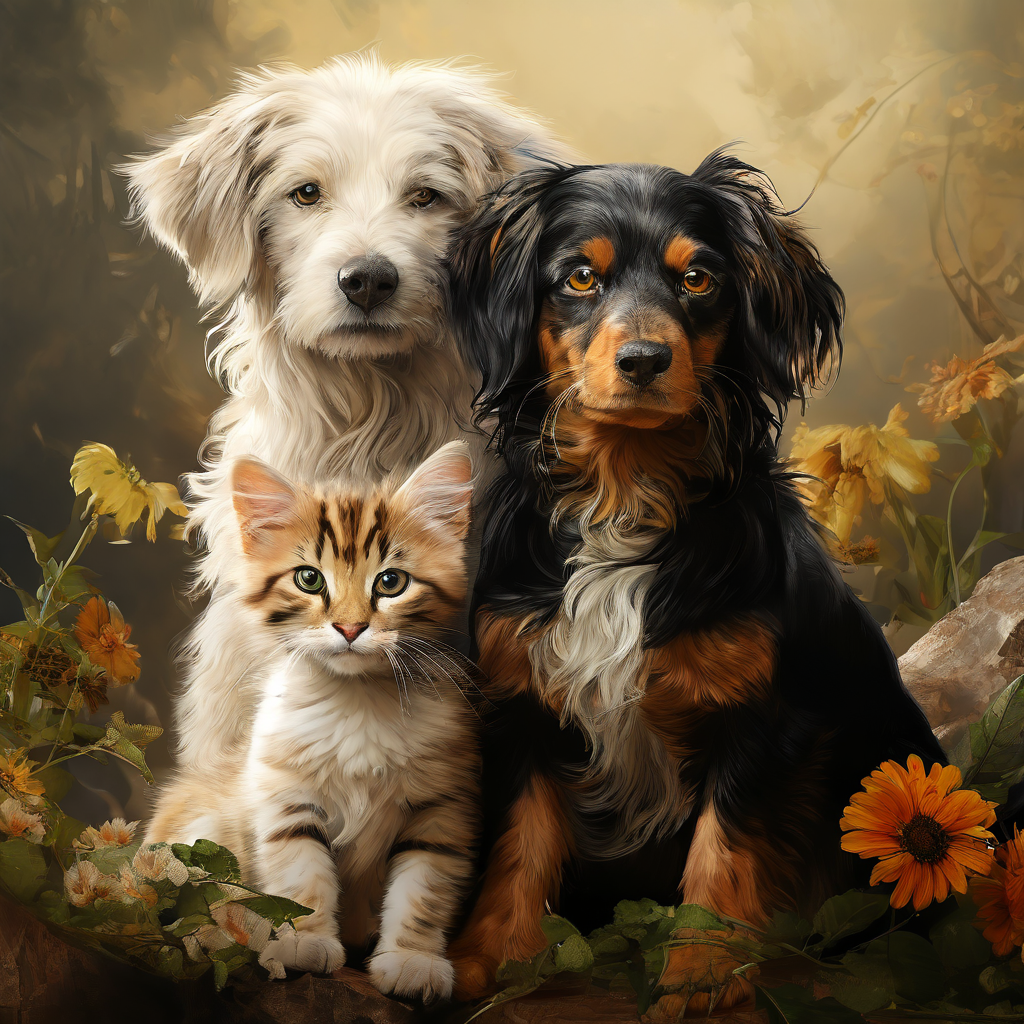

In [ ]:
prompt = f"generate an image of {get_top_categories(audio_classifier_output)}"
image = pipe(prompt=prompt, num_inference_steps=50, guidance_scale=3).images[0]

image